<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>




# 4a. 資料增強(Data Augmentation)


到目前為止，我們已經選擇了一個模型架構，它極大地改善了模型的效能，因為它被設計用來識別圖像中的重要特徵。驗證(Validation)準確度(accuracy)仍然落後於訓練準確度，這是過度擬合(overfitting)的跡象：當模型針對驗證資料集進行測試時，它會被之前未見過的內容所困惑。

為了教導我們的模型在查看新資料時更具強韌性(robust)，我們將以程式化的方式增加資料集的大小和變異性。這被稱為[*資料增強(data augmentation)*](https://link.springer.com/article/10.1186/s40537-019-0197-0)，是許多深度學習應用中的實用技術。

資料量的增加讓模型在訓練時有更多圖像可以學習。變異性的增加幫助模型忽略不重要的特徵，只選擇在分類(Classifier)中真正重要的特徵，使其能夠更好地泛化。


## 4a.1 目標(Objectives)


-   增強(Augment) ASL資料集
-   使用增強的資料訓練改進的模型
-   將訓練好的模型儲存以便部署使用

In [1]:
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True


## 4a.2 準備資料


由於我們在一個新的Notebook中，我們將再次載入和處理我們的資料。要做到這一點，請執行以下程式碼區塊(Cell)：

In [2]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1
N_CLASSES = 24

train_df = pd.read_csv("data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/asl_data/sign_mnist_valid.csv")

class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()
        y_df = x_df.pop('label')
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

n = 32
train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)


## 4a.3 模型建立


我們還需要再次建立我們的模型。正如我們在上一課所學到的，卷積神經網路(CNN)使用重複的層序列。讓我們利用這種模式來製作我們自己的[自定義模組(module)](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html)。然後我們可以在我們的[Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)模型中像使用層(layer)一樣使用這個模組(module)。

為了做到這一點，我們將擴展[Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)類別(class)。然後我們將定義兩個方法：

*   `__init__`：定義我們希望模組(module)具有的任何屬性，包括我們的神經網路層。我們實際上是在模型中使用另一個模型。
*   `forward`：定義我們希望模組如何處理來自它所連接的前一層的任何傳入資料。由於我們使用的是`Sequential`模型，我們可以像做預測一樣將輸入資料傳遞給它。

In [3]:
class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)


現在我們已經定義了自定義模組，讓我們看看它的實際效果。下面的模型在架構上與前一課相同。你能看出其中的關聯嗎？

In [4]:
flattened_img_size = 75 * 3 * 3

# Input 1 x 28 x 28
base_model = nn.Sequential(
    MyConvBlock(IMG_CHS, 25, 0), # 25 x 14 x 14
    MyConvBlock(25, 50, 0.2), # 50 x 7 x 7
    MyConvBlock(50, 75, 0),  # 75 x 3 x 3
    # Flatten to Dense Layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)



當我們印出模型時，它不僅會顯示我們使用的自定義模組，還會顯示我們自定義模組中的層：

In [5]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters())

model = torch.compile(base_model.to(device))
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affin


自定義模組是靈活的，我們可以定義任何其他我們希望擁有的方法或屬性。這使得它們在資料科學家嘗試解決複雜問題時非常強大。

## 4a.4 資料增強(Data Augmentation)


在定義我們的訓練迴圈之前，現在是時候設定我們的資料增強部分了。

我們之前已經見過[TorchVision](https://pytorch.org/vision/stable/index.html)的[Transforms](https://pytorch.org/vision/0.9/transforms.html)，但在這一課中，我們將進一步探索它的資料增強工具。首先，讓我們獲取一個樣本圖像進行測試：

In [6]:
row_0 = train_df.head(1)
y_0 = row_0.pop('label')
x_0 = row_0.values / 255
x_0 = x_0.reshape(IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
x_0 = torch.tensor(x_0)
x_0.shape

torch.Size([1, 28, 28])

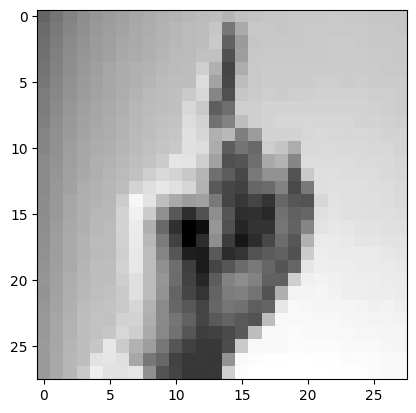

In [7]:
image = F.to_pil_image(x_0)
plt.imshow(image, cmap='gray')

### 4a.4.1 [RandomResizeCrop](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomResizedCrop)



這個轉換(transform)將根據`scale`隨機調整輸入圖像的大小，然後將其[裁剪(crop)](https://en.wikipedia.org/wiki/Cropping_(image))為我們指定的大小。在這種情況下，我們將裁剪它到原始圖像尺寸。為此，TorchVision需要知道它正在縮放的圖像的[長寬比(aspect ratio)](https://en.wikipedia.org/wiki/Aspect_ratio_(image))。由於我們的高度與寬度相同，我們的長寬比`ratio`是1:1。

In [8]:
trans = transforms.Compose([
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.7, 1), ratio=(1, 1)),
])


嘗試多次運行下面的程式碼區塊(Cell)。每次應該都不一樣。

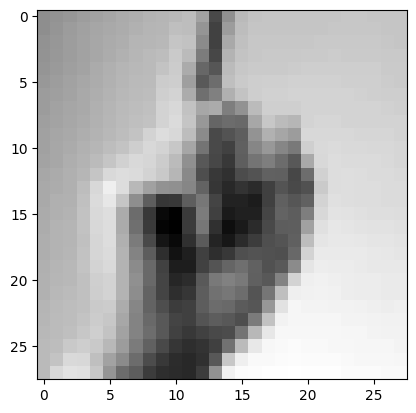

In [9]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

In [10]:
new_x_0.shape

torch.Size([1, 28, 28])

### 4a.4.2 [隨機水平翻轉(RandomHorizontalFlip)](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomHorizontalFlip)


我們還可以隨機[水平](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomHorizontalFlip)或[垂直](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomVerticalFlip)翻轉我們的圖像。然而，這次對於這些圖像，我們只會水平翻轉它們。

花點時間思考為什麼我們想要水平翻轉圖像，而不是垂直翻轉。當你有想法時，可以顯示下面的文字。

`# SOLUTION` 有趣的事實：美國手語可以用左手或右手作為主導手。然而，不太可能看到倒置的手語。這種特定領域的推理可以幫助為你自己的深度學習應用做出良好的決策。

In [11]:
trans = transforms.Compose([
    transforms.RandomHorizontalFlip()
])


嘗試多次運行下面的程式碼區塊(Cell)。圖像是否大約有一半的時間翻轉？

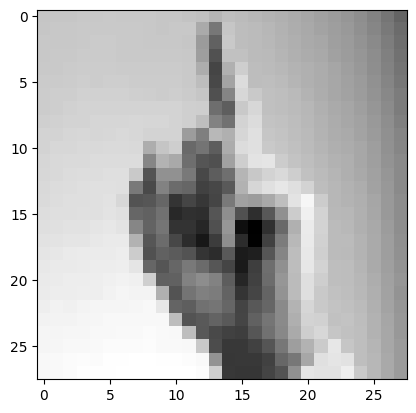

In [12]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.4.3 [隨機旋轉(RandomRotation)](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomRotation)



我們還可以隨機旋轉圖像以增加更多變異性。但就像其他資料增強(augmentation)技術一樣，很容易不小心做了太多處理。對於ASL，如果我們旋轉太多，我們的`D`可能看起來像`G`，反之亦然。因此，讓我們將其限制在`30`度。

In [13]:
trans = transforms.Compose([
    transforms.RandomRotation(10)
])



當我們運行下面的程式碼區塊(Cell)時，可能會出現一些黑色像素。這是由於當我們旋轉時，我們圖像的角落會消失，而且對於我們失去的幾乎每個像素，我們都會獲得一個空像素(pixel)。

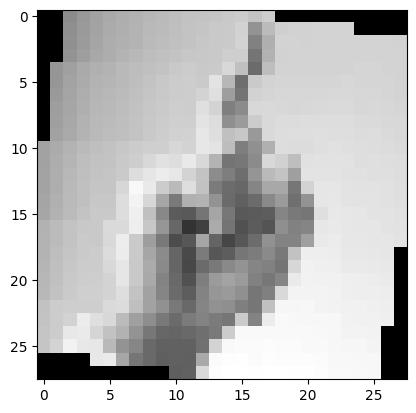

In [14]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.4.3 [ColorJitter](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.ColorJitter)




`ColorJitter`轉換有4個參數：

-   [亮度(brightness)](https://en.wikipedia.org/wiki/Brightness)

-   [對比度(contrast)](https://en.wikipedia.org/wiki/Contrast_(vision))

-   [飽和度(saturation)](https://en.wikipedia.org/wiki/Colorfulness#Saturation)

-   [色調(hue)](https://en.wikipedia.org/wiki/Hue)

後2個適用於彩色圖像，所以我們現在只使用前2個。

In [15]:
brightness = .2  # Change to be from 0 to 1
contrast = .5  # Change to be from 0 to 1

trans = transforms.Compose([
    transforms.ColorJitter(brightness=brightness, contrast=contrast)
])


嘗試多次運行下面的程式碼，但也嘗試將`brightness`或`contrast`更改為`1`。得到任何有趣的結果嗎？

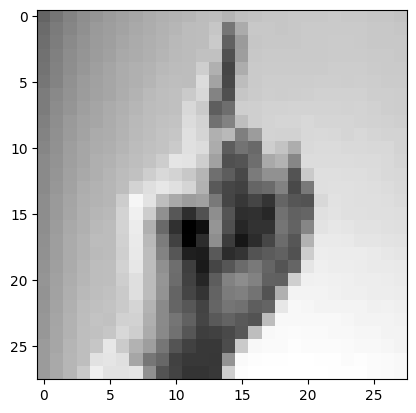

In [16]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.3.4 [Compose](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Compose)



是時候把所有內容整合在一起了。我們可以使用`Compose`創建這些隨機轉換(transformations)的順序組合。

In [17]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.5)
])


讓我們測試一下。有了所有不同的組合，這一張圖像有多少種變化？無限多嗎？

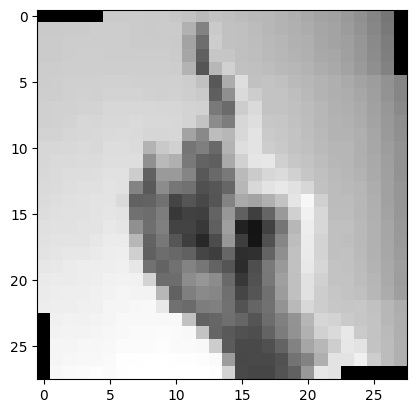

In [18]:
new_x_0 = random_transforms(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')


### 4a.4 使用資料增強進行訓練


我們的訓練大部分相同，但有一行變化。在將我們的圖像傳遞給我們的模型之前，我們將應用我們的`random_transforms`。為了方便起見，我們將`get_batch_accuracy`移到了[utils](./utils.py)文件中。

In [19]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(random_transforms(x))  # Updated
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += utils.get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))


另一方面，驗證(Validation)保持不變。沒有隨機轉換。

In [20]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += utils.get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))


讓我們測試一下資料增強(Data Augmentation)。

In [21]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 646.4932 Accuracy: 0.7549
Valid - Loss: 85.1219 Accuracy: 0.8583
Epoch: 1
Train - Loss: 98.8699 Accuracy: 0.9632
Valid - Loss: 50.3031 Accuracy: 0.9239
Epoch: 2
Train - Loss: 63.6874 Accuracy: 0.9762
Valid - Loss: 20.9530 Accuracy: 0.9732
Epoch: 3
Train - Loss: 35.7816 Accuracy: 0.9867
Valid - Loss: 37.9619 Accuracy: 0.9439
Epoch: 4
Train - Loss: 38.8276 Accuracy: 0.9849
Valid - Loss: 34.4812 Accuracy: 0.9526
Epoch: 5
Train - Loss: 26.9184 Accuracy: 0.9898
Valid - Loss: 11.7717 Accuracy: 0.9806
Epoch: 6
Train - Loss: 25.5494 Accuracy: 0.9897
Valid - Loss: 12.2111 Accuracy: 0.9815
Epoch: 7
Train - Loss: 23.5759 Accuracy: 0.9911
Valid - Loss: 31.1208 Accuracy: 0.9453
Epoch: 8
Train - Loss: 20.0675 Accuracy: 0.9926
Valid - Loss: 15.0231 Accuracy: 0.9763
Epoch: 9
Train - Loss: 17.1133 Accuracy: 0.9934
Valid - Loss: 24.1966 Accuracy: 0.9672
Epoch: 10
Train - Loss: 16.9702 Accuracy: 0.9932
Valid - Loss: 7.0518 Accuracy: 0.9875
Epoch: 11
Train - Loss: 18.6959 Accuracy: 

## 結果討論


你會注意到驗證準確度(Validation accuracy)現在更高，且更一致。這意味著我們的模型不再像以前那樣過度擬合(overfitting)；它泛化(generalizes)得更好，對新資料做出更好的預測。

訓練準確度可能較低，這沒關係。與之前相比，模型接觸到了更多種類的資料。

## 儲存模型


現在我們有了一個訓練良好的模型，我們將希望部署它來對新圖像進行推論(inference)。

通常，一旦我們有了一個我們滿意的訓練好的模型，就會將其儲存到磁碟。PyTorch有[多種方式](https://pytorch.org/tutorials/beginner/saving_loading_models.html)可以做到這一點，但現在，我們將使用`torch.save`。我們還需要儲存我們的`MyConvBlock`自定義模組的程式碼，我們在[utils.py](./utils.py)中做了這個。在下一個Notebook中，我們將載入模型並使用它來讀取新的手語圖片。

PyTorch無法儲存已編譯的模型（[參見此帖子](https://discuss.pytorch.org/t/how-to-save-load-a-model-with-torch-compile/179739)），所以我們將改為

In [ ]:
torch.save(base_model, 'model.pth')

## 總結



在本節中，你使用TorchVision增強(augment)了資料集。這產生了一個訓練好的模型，減少了過度擬合(overfitting)並獲得了優秀的驗證圖像結果。

### 清空記憶體

在繼續之前，請執行以下程式碼區塊(Cell)以清空GPU記憶體。

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## 下一步


現在你已經將訓練好的模型儲存到磁碟，在下一節中，你將部署它來對尚未見過的圖像進行預測。

請繼續下一個Notebook：[*模型預測(Model Predictions)*](04b_asl_predictions.ipynb)。

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>


